In [100]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

using StatsBase
using SparseArrays
using SpecialFunctions

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [101]:
# dataset = "contact-primary-school-classes"
dataset = "email-Enron-full"
# dataset = "walmart-trips"
# dataset = "TrivagoClickout"
kmax_ = 38

H = read_hypergraph_data(dataset,kmax_, 2, false)
α = zeros(2*kmax_);

kmax = maximum(keys(H.E))
kmin = minimum(keys(H.E))

n = length(H.D)

# all-or-nothing
function ω(p,α)
    k = p[2]
    δ = p[1]
    return ((1+(1-δ))*n)^α[k] / (n^α[k + kmax])
end



### Global Params

In [102]:
verbose = false
maxits = 100
randflag = true
# weighted=true
weighted=false

false

# Dyadic

In [125]:
Ω₀ = allOrNothingIntensityFunction(ω, kmax);
α̂ = α

println("")
println("DYADIC (modularity)")
print(rpad("iteration", 20))
print(rpad("Q_D", 15))
print(rpad("L_D", 15))
print(rpad("Q_H", 15))
print(rpad("NMI", 10))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  95, "-"))

Z₀ = collect(1:n)
Ẑ₀ = Z₀

γ₀ = 5.0

best_Z₀  = Z₀
best_γ₀  = γ
best_Ω₀  = Ω₀
best_Q_D₀ = 0
best_ωᵢ = 1
best_ωₒ = 1

for i = 1:10
    
    tic = time()
    
    Z₀ = CliqueExpansionModularity(H, γ₀, weighted, randflag);
    toc = time()-tic
    
    γ₀ = computeDyadicResolutionParameter(H, Z₀)
    ωᵢ, ωₒ = computeDyadicResolutionParameter(H, Z₀; mode="ω", weighted=weighted)
    
    # hypergraph modularity
    Ω₀ = estimateΩEmpirically(H, Z₀; aggregator = p -> [length(p) == 1, sum(p)])
    Q_H = modularity(H, Z₀, Ω₀; α = α̂)
    Q_D₀ = dyadicModularity(H, Z₀, γ₀; weighted=weighted)
    L_D = dyadicLogLikelihood(H, Z₀, ωᵢ, ωₒ; constants = true)
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q_D₀,digits = 2))", 15))
    print(rpad("$(round(L_D,digits = 2))", 15))
    print(rpad("$(round(Q_H))", 15))
    print(rpad("$(round(mutualInformation(Ẑ₀,Z₀,true), digits = 2))", 10))
    print(rpad("$(length(unique(Z₀)))", 10))
    println(rpad("$(round(toc; digits=3))", 10))
    
    Ẑ₀ = Z₀
    
    if Q_D₀ > best_Q_D₀
        best_Z₀, best_γ₀, best_Ω₀, best_Q_D₀, best_ωᵢ, best_ωₒ = Z₀, γ₀, Ω₀, Q_D₀, ωᵢ, ωₒ
    end
end


DYADIC (modularity)
iteration           Q_D            L_D            Q_H            NMI       groups    time (s)  
-----------------------------------------------------------------------------------------------
1                   0.29           -4697.99       -29560.0       0.68      18        0.018     
2                   0.34           -6576.16       -29744.0       0.79      12        0.01      
3                   0.37           -7478.24       -29507.0       0.82      11        0.009     
4                   0.37           -7785.87       -29646.0       0.89      11        0.066     
5                   0.38           -8616.46       -29988.0       0.75      10        0.009     
6                   0.38           -8591.88       -29984.0       0.97      10        0.011     
7                   0.38           -8575.27       -29979.0       0.96      10        0.063     
8                   0.39           -8974.31       -30034.0       0.93      9         0.009     
9                  

In [129]:
print("The optimal partition according to dyadic modularity has ")
println("$(length(unique(b₁_Z₀))) groups, with ")
println(" - modularity $(round(best_Q_D₀, digits = 2))")

best_L_D = dyadicLogLikelihood(H, best_Z₀, best_ωᵢ, best_ωₒ; constants = true)
println(" - dyadic likelihood $(round(best_L_D, digits = 2))")

Q_H = modularity(H, best_Z₀, best_Ω₀; α = α̂)
println(" - polyadic likelihood $(round(Q_H))")

The optimal partition according to dyadic modularity has 8 groups, with 
 - modularity 0.42
 - dyadic likelihood -11362.57
 - dyadic likelihood -30349.0


In [131]:
D = countmap(Ẑ₁)
[(key, val) for (key, val) in D if val > 0]

8-element Array{Tuple{Int64,Int64},1}:
 (7, 1)
 (4, 1)
 (2, 16)
 (3, 41)
 (5, 1)
 (8, 1)
 (6, 1)
 (1, 86)

# Dyadic (likelihood-based)

Some weird things going on here both in terms of evaluating the hypergraph modularity and in terms of obtaining reasonable results from running hypergraph algorithms on the dyadic graph. 

In [132]:
# construct projected graph as hypergraph
A = CliqueExpansion(H, false, false)
ix, jx, w = findnz(A)
E = Dict([ix[k], jx[k]] => w[k] for k in 1:n)

H̄ = hypergraph(collect(1:n), Dict(2 => E), [0])
HypergraphModularity.computeDegrees!(H̄);

In [206]:
println("DYADIC (Likelihood-Based)")
print(rpad("iteration", 20))
print(rpad("Q_D", 15))
print(rpad("L_D", 15))
print(rpad("Q_H", 15))
print(rpad("NMI", 10))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  95, "-"))

Z₁ = CliqueExpansionModularity(H, 1.0);
Ω₁ = estimateΩEmpirically(H̄, Z₁; aggregator = p -> [length(p) == 1, sum(p)])
# Ω₁ = allOrNothingIntensityFunction(ω, kmax);

Ẑ₁ = Z₁

γ₁ = 5.0

best_Z₁  = Z₁
best_γ₁  = γ₁
best_Ω₁  = Ω₁
best_Q_D₁ = 0
best_ωᵢ = 1
best_ωₒ = 0.01
best_L_D = -Inf

ω₀ = 0
ωᵢ = 1

best_Ω_for_metric = 0

for i = 1:10
        
    tic = time()
    Z₁ = SuperNode_PPLouvain(H̄, Ω₁; α = α, verbose = false, Z0 = collect(1:n))
    toc = time()-tic
        
    γ₁ = computeDyadicResolutionParameter(H̄, Z₁)
    ωᵢ, ωₒ = computeDyadicResolutionParameter(H̄, Z₁; mode="ω", weighted=weighted)
    Ω₁ = estimateΩEmpirically(H̄, Z₁; aggregator = p -> [length(p) == 1, sum(p)])
    
    
    Ω_for_metric = estimateΩEmpirically(H, Z₁; aggregator = p -> [length(p) == 1, sum(p)])
    Q_H = modularity(H, Z₁, Ω_for_metric; α = α̂)
    
    Q_D₁ = dyadicModularity(H̄, Z₁, γ₁; weighted=weighted)
    L_D = dyadicLogLikelihood(H̄, Z₁, ωᵢ, ωₒ; constants = true)
    
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q_D₁,digits = 2))", 15))
    print(rpad("$(round(L_D,digits = 2))", 15))
    print(rpad("$(round(Q_H))", 15))
    print(rpad("$(round(mutualInformation(Ẑ₁,Z₁,true), digits = 2))", 10))
    print(rpad("$(length(unique(Z₁)))", 10))
    println(rpad("$(round(toc; digits=3))", 10))
    
    if L_D > best_L_D
        best_Z₁, best_γ₁, best_Ω₁, best_Q_D₁, best_ωᵢ, best_ωₒ, best_L_D, best_Ω_for_metric = Z₁, γ₁, Ω₁, Q_D₁, ωᵢ, ωₒ, L_D, Ω_for_metric
    end
    
    Ẑ₁ = Z₁
end

DYADIC (Likelihood-Based)
iteration           Q_D            L_D            Q_H            NMI       groups    time (s)  
-----------------------------------------------------------------------------------------------
1                   0.19           -921.41        -31089.0       0.47      94        0.002     
2                   0.18           -897.54        -31072.0       0.98      98        0.002     
3                   0.18           -893.63        -31084.0       0.99      98        0.002     
4                   0.18           -904.8         -31068.0       0.98      97        0.002     
5                   0.18           -908.95        -31062.0       0.97      96        0.002     
6                   0.18           -904.11        -31070.0       0.97      97        0.002     
7                   0.18           -905.37        -31079.0       0.99      97        0.067     
8                   0.18           -912.05        -31078.0       0.97      96        0.001     
9             

In [207]:
print("The optimal partition according to dyadic likelihood has ")
println("$(length(unique(best_Z₁))) groups, with ")
println(" - modularity $(round(best_Q_D₁, digits = 2))")

println(" - dyadic likelihood $(round(best_L_D, digits = 2))")

Q_H = modularity(H, best_Z₁, best_Ω_for_metric; α = α̂)
println(" - polyadic likelihood $(round(Q_H))")

The optimal partition according to dyadic likelihood has 98 groups, with 
 - modularity 0.18
 - dyadic likelihood -893.63
 - polyadic likelihood -31084.0


In [208]:
best_Ω₁.ω([0, 2],α), best_Ω₁.ω([1, 2],α)

(0.005104843139155439, 0.01995022166912966)

In [209]:
best_ωₒ, best_ωᵢ

(0.6863616653631863, 1.391747567255347)

# Polyadic

In [179]:
# Zwarm = collect(1:n)  # no warm start
Z_ = CliqueExpansionModularity(H, 15.0);

Ω₂ = estimateΩEmpirically(H, Z_; aggregator = p -> [length(p) == 1, sum(p)], bigNums = bigNums)
Q₂ = modularity(H, Z_, Ω₂; α = α)


best_Z₂  = collect(1:n)
best_γ₂  = γ
best_Ω₂  = Ω
best_Q₂  = -Inf
best_ωᵢ = 1
best_ωₒ = 1

println("Warmstart partition has $(maximum(Z_)) clusters and modularity $(round(Q)).")
println("")


println("")
println("POLYADIC")
print(rpad("iteration", 20))
print(rpad("Q_D", 15))
print(rpad("L_D", 15))
print(rpad("Q_H", 15))
print(rpad("NMI", 10))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  95, "-"))

for i = 1:10
    
    tic = time()
    Z₂ = SuperNode_PPLouvain(H, Ω₂; α = α, verbose = false, Z0 = collect(1:n))
    toc = time()-tic
        
    Ω₂ = estimateΩEmpirically(H, Z₂; aggregator = p -> [length(p) == 1, sum(p)], bigNums = bigNums)
    Q₂ = modularity(H, Z₂, Ω₂; α = α̂)
    
    
    γ₂ = computeDyadicResolutionParameter(H, Z₂)
    ωᵢ, ωₒ = computeDyadicResolutionParameter(H, Z₂; mode="ω", weighted=weighted)
    
    # hypergraph modularity
    Q_D₂ = dyadicModularity(H, Z₂, γ₂; weighted=weighted)
    L_D₂ = dyadicLogLikelihood(H, Z₂, ωᵢ, ωₒ; constants = true)
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q_D₂,digits = 2))", 15))
    print(rpad("$(round(L_D₂,digits = 2))", 15))
    print(rpad("$(round(Q₂))", 15))
    print(rpad("$(round(mutualInformation(Ẑ₂,Z₂,true), digits = 2))", 10))
    print(rpad("$(length(unique(Z₂)))", 10))
    println(rpad("$(round(toc; digits=3))", 10))
    
    Ẑ₂ = Z₂
    
    if Q₂ > best_Q₂
        best_Z₂, best_γ₂, best_Ω₂, best_Q₂, best_ωᵢ, best_ωₒ = Z₂, γ₂, Ω₂, Q₂, ωᵢ, ωₒ
    end
end

Warmstart partition has 41 clusters and modularity -29885.0.


POLYADIC
iteration           Q_D            L_D            Q_H            NMI       groups    time (s)  
-----------------------------------------------------------------------------------------------
1                   0.13           -3093.58       -29929.0       0.78      33        0.056     
2                   0.14           -3274.5        -29882.0       0.9       30        0.128     
3                   0.18           -3886.88       -29720.0       0.86      25        0.063     
4                   0.26           -4790.63       -29418.0       0.76      17        0.048     
5                   0.27           -4898.99       -29384.0       0.89      17        0.048     
6                   0.24           -4770.12       -29506.0       0.88      20        0.043     
7                   0.27           -4980.31       -29380.0       0.87      17        0.05      
8                   0.27           -5009.71       -29386.0      

In [180]:
print("The optimal partition according to hypergraph modularity has ")
println("$(length(unique(Z₂))) groups, with ")

best_Q_D₂ = dyadicModularity(H, best_Z₂, best_γ₂; weighted=weighted)
println(" - modularity $(round(best_Q_D₂, digits = 2))")

best_L_D = dyadicLogLikelihood(H, best_Z₂, best_ωᵢ, best_ωₒ; constants = true)
println(" - dyadic likelihood $(round(best_L_D, digits = 2))")

Q_H = modularity(H, best_Z₀, best_Ω₀; α = α̂)
println(" - polyadic likelihood $(round(best_Q₂))")

The optimal partition according to hypergraph modularity has 17 groups, with 
 - modularity 0.27
 - dyadic likelihood -4980.31
 - polyadic likelihood -29380.0


In [175]:
D = countmap(Ẑ₂)
[(key, val) for (key, val) in D if val > 0]

17-element Array{Tuple{Int64,Int64},1}:
 (2, 9)
 (16, 3)
 (11, 1)
 (7, 15)
 (9, 18)
 (10, 17)
 (17, 1)
 (8, 1)
 (6, 10)
 (4, 12)
 (3, 13)
 (5, 17)
 (13, 1)
 (14, 1)
 (15, 1)
 (12, 18)
 (1, 10)

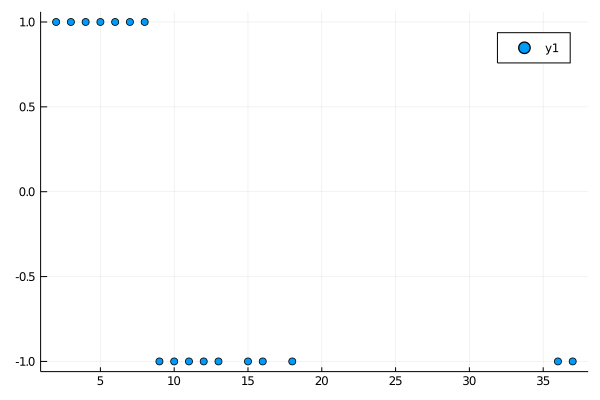

In [68]:
# plot the sign of the difference between the within- and between intensities. 

using Plots

K = [k for k in keys(H.E) if length(H.E[k]) > 0]

v = [(Ω.ω([1, k], α) - Ω.ω([0, k], α)) for k in K]

V = sign.(v)


plot(K, V, seriestype = :scatter)

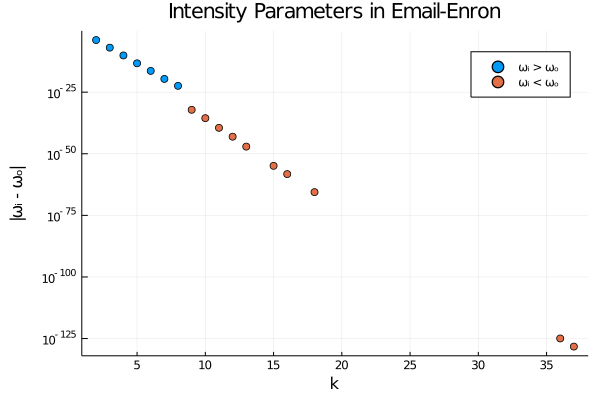

In [69]:
# plot the sign of the difference between the within- and between intensities. 

using Plots

K = [k for k in keys(H.E) if length(H.E[k]) > 0]

v = [(Ω.ω([1, k], α) - Ω.ω([0, k], α)) for k in K]

V = v

# plot(K, abs.(V), seriestype = :scatter, yaxis = :log)
plot(K[V .> 0], V[V .> 0], seriestype = :scatter, yaxis = :log, label = "ωᵢ > ωₒ")
plot!(K[V .< 0], abs.(V[V .< 0]), seriestype = :scatter, yaxis = :log, label = "ωᵢ < ωₒ")
xlabel!("k")
ylabel!("|ωᵢ - ωₒ|")
title!("Intensity Parameters in Email-Enron")

In [95]:
function q(k)
    Hk = hypergraph(1:n, Dict(k => H.E[k]), [0])
    HypergraphModularity.computeDegrees!(Hk)
    return (modularity(Hk, Ẑ₂, Ω; α = α̂))
end

K = [k for k in keys(H.E) if length(H.E[k]) > 0]

Qvec = q.(K) 

17-element Array{BigFloat,1}:
  -694.6179308198394850848106095390979825143241466412170882703176822753314939129799
  -302.0415206638317985861843222714318534850724292066485854771626786761253476180787
 -7947.5373775588282425709325492747814312366472222493030130863189697265625
  -268.3213562587200525257337689903930497067960161549585233649704388738547798201842
  -545.6249251746461719385134652795885709420841412632375846941565571122482690500654
 -1437.750207146383273682367271368904628615063239781633101727209468093607558561939
  -444.4338087124826607997246659318432731861510853281679861106399563630431480716118
  -901.1258647143650571498756065502747864354063265484411896968869757270254122202347
 -1333.696229115963617662149885768446861926346038330559402943538570942685291809606
 -1856.174550698704647116611977224083191723699135472111172317463581687051481353257
 -3576.741414169886431418640929434399529130167872806817322157285632400203212455381
  -295.4013537641716585842779741448384300819252103315735853

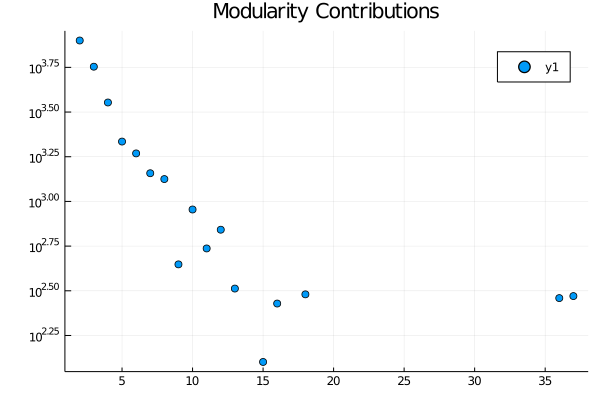

In [96]:
plot(collect(K), -Qvec, seriestype = :scatter, yaxis = :log)
title!("Modularity Contributions")

In [98]:
print([(k, length(H.E[k])) for k in keys(H.E)])

[(1, 0), (12, 7), (18, 2), (32, 0), (2, 809), (16, 2), (11, 6), (21, 0), (7, 27), (9, 6), (25, 0), (10, 11), (26, 0), (29, 0), (34, 0), (35, 0), (19, 0), (17, 0), (8, 22), (22, 0), (6, 43), (24, 0), (4, 138), (37, 1), (3, 317), (28, 0), (5, 63), (20, 0), (23, 0), (13, 3), (14, 0), (31, 0), (27, 0), (36, 1), (15, 1), (33, 0), (30, 0)]